In [60]:
#Create references to important directories we will use over and over
import os, sys
from glob import glob
import numpy as np
DATA_HOME_DIR = '/Users/gapon/work/fast_ai/data/mushrooms'

In [67]:
categories = os.listdir(DATA_HOME_DIR + '/train')
categories.remove('.DS_Store')

bash_categories = ''
for c in categories:
    bash_categories += c + ' '

## Create validation and test folders

In [70]:
%%bash -s "$bash_categories"
cd ~/work/fast_ai/data/mushrooms/
for dir in $1
do
    mkdir -p valid/$dir
    mkdir -p test/$dir
done

## Rename JPG to jpg

In [90]:
%%bash
for dir in blednaya_poganka panter_muhomor podgruzdok_cherny red_muhomor syroegka_berezovaya false_lisichka gruzd_cherny lisichka white;
    do cd ~/work/fast_ai/data/mashrooms/train/$dir
    for f in *.JPG; 
        do mv "$f" "${f/.JPG/}.jpg"
    done
done

mv: rename *.JPG to *.jpg: No such file or directory
mv: rename *.JPG to *.jpg: No such file or directory
mv: rename *.JPG to *.jpg: No such file or directory
mv: rename *.JPG to *.jpg: No such file or directory
mv: rename *.JPG to *.jpg: No such file or directory
mv: rename *.JPG to *.jpg: No such file or directory
mv: rename *.JPG to *.jpg: No such file or directory
mv: rename *.JPG to *.jpg: No such file or directory
mv: rename *.JPG to *.jpg: No such file or directory


## Create validation set

In [102]:
%cd ~/work/fast_ai/data/mashrooms/train

VAL_SIZE = 0.2
#TEST_SIZE = 0.1
for c in categories:
    g = glob(c + '/*.jpg')
    shuf = np.random.permutation(g)
    
    val = round(len(shuf)*VAL_SIZE)
    #tst = round(len(shuf)*VAL_SIZE)
    #print(val)
    for i in range(val):
        os.rename(shuf[i], DATA_HOME_DIR + '/valid/' + shuf[i])
    print('{0}: {1}'.format(c, val))

/Users/gapon/work/fast_ai/data/mashrooms/train
122
130
62
113
63
104
64
66
62


## Create test set

In [105]:
%cd ~/work/fast_ai/data/mashrooms/train

TST_SIZE = 0.05

for c in categories:
    g = glob(c + '/*.jpg')
    shuf = np.random.permutation(g)
    tst = round(len(shuf)*TST_SIZE)
    for i in range(tst):
        os.rename(shuf[i], DATA_HOME_DIR + '/test/' + shuf[i])
    print('{0}: {1}'.format(c, tst))

/Users/gapon/work/fast_ai/data/mashrooms/train
blednaya_poganka: 24
panter_muhomor: 26
podgruzdok_cherny: 12
red_muhomor: 23
syroegka_berezovaya: 13
false_lisichka: 21
gruzd_cherny: 13
lisichka: 13
white: 12


# VGG16 model setup

In [37]:
from numpy.random import random, permutation
#from scipy import misc, ndimage
#from scipy.ndimage.interpolation import zoom

#import keras
from keras import backend as K
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
# Droput Dense
from keras.layers.core import Dense, Dropout, Lambda, Flatten
from keras.layers import Input
#use
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adam#, SGD, RMSprop
from keras.preprocessing import image
import json
import numpy as np

Import the mappings from VGG ids to imagenet category ids

In [2]:
FILE_PATH = 'http://files.fast.ai/models/'
CLASS_FILE='imagenet_class_index.json'

fpath = get_file(CLASS_FILE, FILE_PATH+CLASS_FILE, cache_subdir='models')

with open(fpath) as f:
    class_dict = json.load(f)

# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

## Model creation

Creating the model involves creating the model architecture, and then loading the model weights into that architecture. We will start by defining the basic pieces of the VGG architecture.

VGG has just one type of convolutional block, and one type of fully connected ('dense') block. Here's the convolutional block definition:

In [3]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Conv2D(filters, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    # For TF data_format="channels_last"; for TH data_format="channels_first" ?

Here's the fully-connected definition.

In [4]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermore, their software that expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:

In [5]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

Now we're ready to define the VGG model architecture - look at how simple it is, now that we have the basic blocks defined!

In [6]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224),output_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

Now that we've defined the architecture, we can create the model like any python object:

In [7]:
model = VGG_16()

Download pre-trained weights

In [9]:
#WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
#fpath = get_file('vgg16.h5', WEIGHTS_PATH, cache_subdir='models')
fpath = get_file('vgg16.h5', FILE_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

# Getting imagenet predictions

In [21]:
%matplotlib inline
from utils import plots
batch_size = 3
path = "data/mashrooms/"

Keras provides functionality to create batches of data from directories containing images; all we have to do is to define the size to resize the images to, what type of labels to create, whether to randomly shuffle the images, and how many images to include in each batch. We use this little wrapper to define some helpful defaults appropriate for imagenet data:

In [23]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

Found 3027 images belonging to 9 classes.


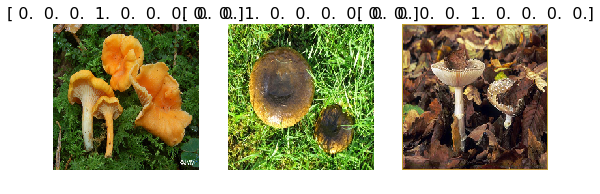

In [22]:
batches = get_batches('train', batch_size=batch_size)
# val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

In [24]:
pred_batch(imgs)

Shape: (3, 1000)
First 5 classes: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']
First 5 probabilities: [  3.9054e-09   2.0260e-07   7.4934e-11   4.8112e-11   5.2571e-10]

Predictions prob/class: 
  0.4037/coral_fungus
  0.4395/tick
  0.8837/mushroom


# Finetune VGG16 model for mushrooms

In [26]:
batch_size = 4
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)

Found 3027 images belonging to 9 classes.
Found 786 images belonging to 9 classes.


In [40]:
    def ft(model, num):
        """
            Replace the last layer of the model with a Dense (fully connected) layer of num neurons.
            Will also lock the weights of all layers except the new layer so that we only learn
            weights for the last layer in subsequent training.

            Args:
                num (int) : Number of neurons in the Dense layer
            Returns:
                None
        """
        model.pop()
        for layer in model.layers: layer.trainable=False
        model.add(Dense(num, activation='softmax'))
        compile(model)

    def finetune(model, batches):
        """
            Modifies the original VGG16 network architecture and updates self.classes for new training data.
            
            Args:
                batches : A keras.preprocessing.image.ImageDataGenerator object.
                          See definition for get_batches().
        """
        ft(model, batches.num_class)
        classes = list(iter(batches.class_indices)) # get a list of all the class labels
        
        # batches.class_indices is a dict with the class name as key and an index as value
        # eg. {'cats': 0, 'dogs': 1}

        # sort the class labels by index according to batches.class_indices and update model.classes
        for c in batches.class_indices:
            classes[batches.class_indices[c]] = c
        model.classes = classes


    def compile(model, lr=0.001):
        """
            Configures the model for training.
            See Keras documentation: https://keras.io/models/model/
        """
        model.compile(optimizer=Adam(lr=lr),
                loss='categorical_crossentropy', metrics=['accuracy'])
        
        
    def fit(model, batches, val_batches, epochs=1):
        """
            Fits the model on data yielded batch-by-batch by a Python generator.
            See Keras documentation: https://keras.io/models/model/
        """
        model.fit_generator(batches, steps_per_epoch=batches.samples//batches.batch_size, epochs=epochs, validation_steps=val_batches.samples//val_batches.batch_size)



In [41]:
finetune(model, batches)

In [43]:
fit(model, batches, val_batches, epochs=1)

Epoch 1/1
 47/756 [>.............................] - ETA: 1526s - loss: 3.9344 - acc: 0.3191

Exception in thread Thread-40:
Traceback (most recent call last):
  File "/Users/gapon/anaconda3/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/gapon/anaconda3/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/gapon/anaconda3/lib/python3.5/site-packages/keras/engine/training.py", line 612, in data_generator_task
    generator_output = next(self._generator)
  File "/Users/gapon/anaconda3/lib/python3.5/site-packages/keras/preprocessing/image.py", line 732, in __next__
    return self.next(*args, **kwargs)
  File "/Users/gapon/anaconda3/lib/python3.5/site-packages/keras/preprocessing/image.py", line 1031, in next
    target_size=self.target_size)
  File "/Users/gapon/anaconda3/lib/python3.5/site-packages/keras/preprocessing/image.py", line 322, in load_img
    img = pil_image.open(path)
  File "/Users/gapon/anaconda3/lib/python3.5/site-packages/PIL/Image.py", line 2410, in open
    fp = buil

 48/756 [>.............................] - ETA: 1522s - loss: 3.8633 - acc: 0.3281

ValueError: output of generator should be a tuple `(x, y, sample_weight)` or `(x, y)`. Found: None

In [ ]:
from PIL import Image
# mirror image
img = Image.open('data/mushrooms/train/6.jpg')
mirror = img.transpose(Image.FLIP_LEFT_RIGHT)
mirror.save('6mir.jpg')

In [85]:
img = Image.open('data/mushrooms/train/6.jpg')
rot = img.rotate(-45)
rot.save('data/mushrooms/train/rot-45.jpg')

# Temp

In [51]:
a = 'aa'
b = ['a', 'b', 'c']
bash_str = ''
for c in b: bash_str += c + ' '
print(str(bash_str))

a b c 


In [53]:
%%bash -s "$bash_str"
for dir in $1
do
    echo $dir
    echo 'done'
done

a
done
b
done
c
done
